In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline 

In [3]:
import os
from glob import glob
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.optimize import lsq_linear
from sklearn.linear_model import LinearRegression
import pickle

## Configuration

### Plotting styling

In [6]:
colors = {}
colors['Threshold0'] = 'black'
colors['Threshold'] = 'black'
colors['Mixedbcstc'] = 'black'
colors['AutoEncoderStride'] = 'tab:blue'
colors['AutoEncoderStridePairHuber'] = 'tab:green'
colors['AutoEncoderStridePairMSE'] = 'tab:olive'
colors['AutoEncoderStrideAEMSE'] = 'tab:orange'
colors['AutoEncoderStrideAEHuber']= 'tab:red'
colors['AutoEncoderStrideAEMSLE'] = 'tab:brown'
colors['AutoEncoderStrideAppMSE']  = 'tab:blue' 
colors['AutoEncoderStrideAPPHuber'] = 'tab:cyan' 
colors['AutoEncoderStrideAPPMSLE'] = 'tab:purple' 
#qkeras models
colors['AutoEncoderEMDAEMSE'] = 'tab:pink'
colors['AutoEncoderEMDPAIRHUBER'] = 'tab:brown'
colors['AutoEncoderTelescopeMSE'] = 'tab:gray'

styles = {}
styles['Threshold0'] = '-'
styles['Threshold'] = '-.'
styles['Mixedbcstc'] = '--'
styles['AutoEncoderStride'] = '-'
styles['AutoEncoderStridePairHuber'] = '--'
styles['AutoEncoderStridePairMSE'] = '--'
styles['AutoEncoderStrideAEMSE'] = '--'
styles['AutoEncoderStrideAEHuber']= '--'
styles['AutoEncoderStrideAEMSLE'] = '--'
styles['AutoEncoderStrideAppMSE']  = '--' 
styles['AutoEncoderStrideAPPHuber'] = '--' 
styles['AutoEncoderStrideAPPMSLE'] = '--' 

styles['AutoEncoderEMDAEMSE'] = '--'
styles['AutoEncoderEMDPAIRHUBER']= '--'
styles['AutoEncoderTelescopeMSE'] = '--'

markers = {}
markers['Threshold0'] =  'o'
markers['Threshold'] = 'o'
markers['Mixedbcstc'] = 'o'
markers['AutoEncoderStride'] = 'o'
markers['AutoEncoderStridePairHuber'] = 'o'
markers['AutoEncoderStridePairMSE'] = 'o'
markers['AutoEncoderStrideAEMSE'] = 'o'
markers['AutoEncoderStrideAEHuber']= 'o'
markers['AutoEncoderStrideAEMSLE'] = 'o'
markers['AutoEncoderStrideAppMSE']  = 'o' 
markers['AutoEncoderStrideAPPHuber'] = 'o' 
markers['AutoEncoderStrideAPPMSLE'] = 'o' 

markers['AutoEncoderEMDAEMSE'] = 'o'
markers['AutoEncoderEMDPAIRHUBER']= 'o'
markers['AutoEncoderTelescopeMSE'] = 'o'

legends = {}
legends['Threshold0'] = 'All TC'
legends['Threshold'] = 'Threshold 1.35 mipT'
legends['Mixedbcstc'] = 'BC+STC'
legends['AutoEncoderStride'] = 'Loss: Tele'
legends['AutoEncoderStridePairHuber'] = 'Loss: Pair Huber'
legends['AutoEncoderStridePairMSE'] = 'Loss: Pair MSE'
legends['AutoEncoderStrideAEMSE'] = 'Loss: AE MSE'
legends['AutoEncoderStrideAEHuber']= 'Loss: AE Huber'
legends['AutoEncoderStrideAEMSLE'] = 'Loss: AE MSLE'
legends['AutoEncoderStrideAppMSE']  = 'Loss: APP MSE' 
legends['AutoEncoderStrideAPPHuber'] = 'Loss: APP Huber' 
legends['AutoEncoderStrideAPPMSLE'] = 'Loss: APP MSLE'

legends['AutoEncoderEMDAEMSE']  = 'QAE w/ Loss: AE MSE'
legends['AutoEncoderEMDPAIRHUBER'] = 'QAE w/ Loss: Pair Huber'
legends['AutoEncoderTelescopeMSE'] = 'QAE w/Tele'

ref_name = 'Threshold0'

plotted_algo = ['Threshold0',
                'Threshold',
                'Mixedbcstc',
                'AutoEncoderStride',
                'AutoEncoderStrideAEMSE',
                'AutoEncoderStrideAppMSE',
                'AutoEncoderStridePairHuber',
                'AutoEncoderStridePairMSE',
                'AutoEncoderStrideAEHuber',
                'AutoEncoderStrideAEMSLE',
                'AutoEncoderStrideAPPHuber',
                'AutoEncoderStrideAPPMSLE',
                'AutoEncoderEMDAEMSE',
                'AutoEncoderEMDPAIRHUBER',
                'AutoEncoderTelescopeMSE']


[]

"""
Keys
10_18_1 ['AutoEncoderStrideAEMSE', 'AutoEncoderStrideAppMSE', 'AutoEncoderStridePairHuber', 'AutoEncoderStridePairMSE', ]>
11_8_1  ['AutoEncoderStrideAEHuber', 'AutoEncoderStrideAEMSLE', 'AutoEncoderStrideAPPHuber', 'AutoEncoderStrideAPPMSLE', ]
11_22_1(QKERAS) = ['Threshold','Threshold0','Mixedbcstc','AutoEncoderTelescopeMSE','AutoEncoderEMDAEMSE','AutoEncoderEMDPAIRHUBER']
>
"""

"\nKeys\n10_18_1 ['AutoEncoderStrideAEMSE', 'AutoEncoderStrideAppMSE', 'AutoEncoderStridePairHuber', 'AutoEncoderStridePairMSE', ]>\n11_8_1  ['AutoEncoderStrideAEHuber', 'AutoEncoderStrideAEMSLE', 'AutoEncoderStrideAPPHuber', 'AutoEncoderStrideAPPMSLE', ]\n11_22_1(QKERAS) = ['Threshold','Threshold0','Mixedbcstc','AutoEncoderTelescopeMSE','AutoEncoderEMDAEMSE','AutoEncoderEMDPAIRHUBER']\n>\n"

### Input files and FE algorithms to be studied
Both 200PU electron gun and 0PU photon guns are loaded

In [7]:
version = '101801'
fig_dir = 'img/electron_photon_calib_autoencoder_{}'.format(version)
algo_files = {}
# Read  first set
directory1 = '/home/cms.rshenoy/10_18_1/electron_photon_signaldriven/v_1_2021-10-23'
directory2 = '/home/cms.rshenoy/11_8_1/electron_photon_signaldriven/v_1_2021-11-08'
directory3 = '/home/cms.rshenoy/11_22_1/electron_photon_signaldriven/v_1_2021-12-01'
fes = ['Threshold0',
                'Threshold',
                'Mixedbcstc',
                'AutoEncoderStride',
                'AutoEncoderStrideAEMSE',
                'AutoEncoderStrideAppMSE',
                'AutoEncoderStridePairHuber',
                'AutoEncoderStridePairMSE',
                'AutoEncoderStrideAEHuber',
                'AutoEncoderStrideAEMSLE',
                'AutoEncoderStrideAPPHuber',
                'AutoEncoderStrideAPPMSLE',
                'AutoEncoderEMDAEMSE',
                'AutoEncoderEMDPAIRHUBER','AutoEncoderTelescopeMSE']


In [8]:
for fe in fes:
    if(fe=='AutoEncoderStride'or fe=='AutoEncoderStrideAEMSE'or fe=='AutoEncoderStrideAppMSE'or fe== 'AutoEncoderStridePairHuber'or fe== 'AutoEncoderStridePairMSE'):
        algo_files[fe] = (glob(directory1+'/electrons/*.hdf5'), glob(directory1+'/photons/*.hdf5'))
    elif(fe=='AutoEncoderStrideAEHuber'or fe=='AutoEncoderStrideAEMSLE'or fe=='AutoEncoderStrideAPPHuber'or fe=='AutoEncoderStrideAPPMSLE'):
        algo_files[fe] = (glob(directory2+'/electrons/*.hdf5'), glob(directory2+'/photons/*.hdf5'))
    elif(fe=='AutoEncoderEMDAEMSE' or fe=='AutoEncoderEMDPAIRHUBER' or fe=='AutoEncoderTelescopeMSE'):
        algo_files[fe] = (glob(directory3+'/electrons/*.hdf5'), glob(directory3+'/photons/*.hdf5'))
    else:
        algo_files[fe] = (glob(directory2+'/electrons/*.hdf5'), glob(directory2+'/photons/*.hdf5'))
        #expert algos

## Loading and preprocessing dataframes

In [9]:
algos_dfs = {}
for fe,files in algo_files.items():
    name = fe
    dfs = []
    for file in files[0]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    for file in files[1]:
        store = pd.HDFStore(file, mode='r')
        dfs.append(store[name])
        store.close()
    algos_dfs[fe] = pd.concat(dfs)
algo_names = sorted(algos_dfs.keys())

Selection cuts (in addition to those already applied before):
- Gen particle $p_T > 5 GeV$
- Cluster $p_T > 3 GeV$
- Extrapolated gen particle eta between 1.6 and 2.9

Additionally label electrons and positrons as `0` and photons as `1`.

In [11]:
ptcut=5
clptcut=3
etamin=1.6
etamax=2.9
algo_cut={}
for name,df in algos_dfs.items():
    sel = df['genpart_pt']>ptcut
    algo_cut[name] = df[sel]
    sel = algo_cut[name]['cl3d_pt']>clptcut
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])>etamin
    algo_cut[name] = algo_cut[name][sel]
    sel = np.abs(algo_cut[name]['genpart_exeta'])<etamax
    algo_cut[name] = algo_cut[name][sel]
    sel = algo_cut[name]['matches']==True
    algo_cut[name] = algo_cut[name][sel]
    #algo_cut[name].dropna(inplace=True)
    algo_cut[name]['genpart_pid'].replace([-11,11],1, inplace=True)
    algo_cut[name]['genpart_pid'].replace([22],0, inplace=True)

In [12]:
for name,df in algo_cut.items():
    df['cl3d_abseta'] = np.abs(df.cl3d_eta)

## Energy corrections
### Layer weights
On 0PU photon clusters:
- Select layer pTs in the ECAL, dropping the first layer as it doesn't bring anything in the e/g energy and is polluted by PU
- Apply linear regression to find multiplicative coeff. to be applied to each layer pT. These coeff. are bounded between 0 and 2 to avoid large correction factors

In [13]:
layer_coeffs = {}
for name,df in algo_cut.items():
    print(name)
    # select layers [2,14]
    select = df.query('genpart_pid==0')
    layers = np.array(select['cl3d_layer_pt'].tolist())[:,2:15]
    regression = lsq_linear(layers, select['genpart_pt'],
                              bounds = (0.,2.0),
                              method='bvls',
                              lsmr_tol='auto',
                              verbose=1)
    layer_coeffs[name] = regression.x
    print(regression.x)

Threshold0
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 1.5748e+05, final cost 6.8491e+04, first-order optimality 6.45e-09.
[2.         0.78481414 1.18365569 0.92988944 1.03620326 1.10678243
 0.97273912 1.1451926  0.99622551 0.62170175 1.05548903 2.
 2.        ]
Threshold
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 1.4195e+05, final cost 7.1733e+04, first-order optimality 5.92e-09.
[1.98674042 0.84871352 1.18466537 0.94066086 1.04534741 1.1187266
 0.9608574  1.17176152 1.01398139 0.62805343 1.0197385  2.
 2.        ]
Mixedbcstc
The relative change of the cost function is less than `tol`.
Number of iterations 4, initial cost 1.5350e+05, final cost 8.0508e+04, first-order optimality 6.52e-09.
[1.99855585 0.77921598 1.26571567 0.90184872 1.03150641 1.48773877
 0.90480224 1.25723926 1.1686662  0.92272128 1.25012085 2.
 2.        ]
AutoEncoderStride
The relative change of the cost func

Apply layer weights and compute ratios wrt the gen $p_T$ and plot the weight values

In [14]:
# Apply calibration
for name,df in algo_cut.items():
    layers = np.array(df['cl3d_layer_pt'].tolist())[:,2:15]
    df['cl3d_pt_calib'] = np.dot(layers, layer_coeffs[name])
    df['cl3d_over_gen_pt'] = df['cl3d_pt']/df['genpart_pt']
    df['calib_over_gen_pt'] = df['cl3d_pt_calib']/df['genpart_pt']

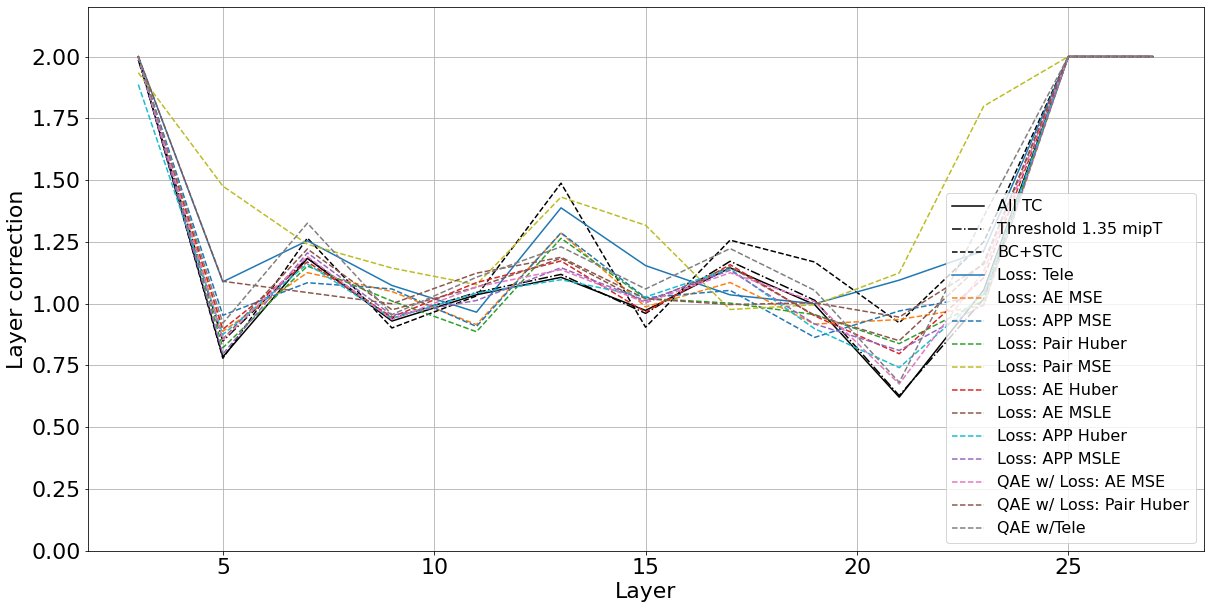

In [15]:
matplotlib.rcParams.update({'font.size': 22})
plt.figure(figsize=(20,10))
for name,weights in layer_coeffs.items():
    plt.plot(range(3, 29, 2), weights, label=legends[name], color=colors[name], ls=styles[name])
plt.ylim(0., 2.2)
plt.legend(fontsize=16)
plt.grid()
plt.xlabel('Layer')
plt.ylabel('Layer correction')
plt.show()

Check impact of layer corrections on the energy ratio distributions

Raw mean=0.9606195092201233, rms=0.032879360020160675, rms/mean=0.034227244555950165
Calib mean=0.9987665771643542, rms=0.04018569572478499, rms/mean=0.04023532289083813


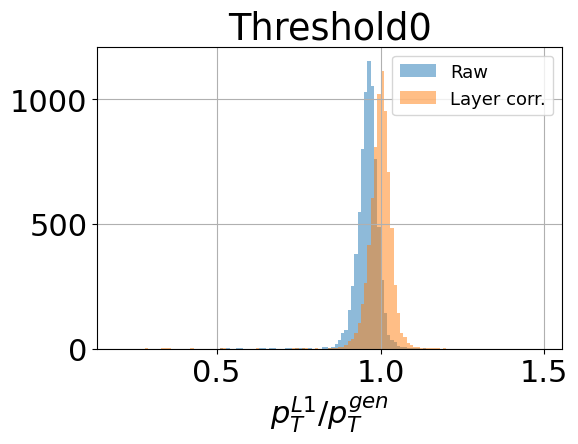

Raw mean=0.940360426902771, rms=0.039580028504133224, rms/mean=0.0420902743935585
Calib mean=0.9873233859474506, rms=0.045663073507915014, rms/mean=0.04624935877933858


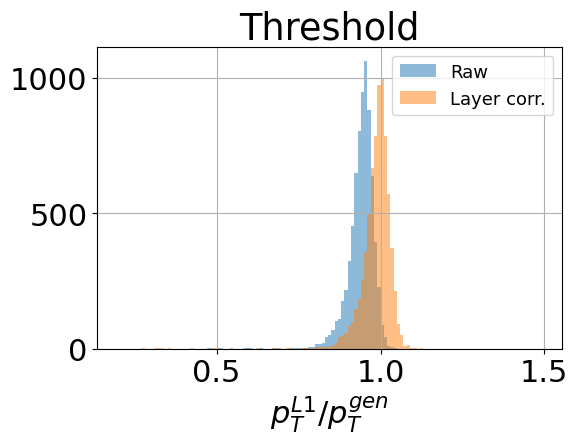

Raw mean=0.8866851329803467, rms=0.03558803349733353, rms/mean=0.04013604298233986
Calib mean=1.001700042021049, rms=0.04321261663975413, rms/mean=0.0431392780543041


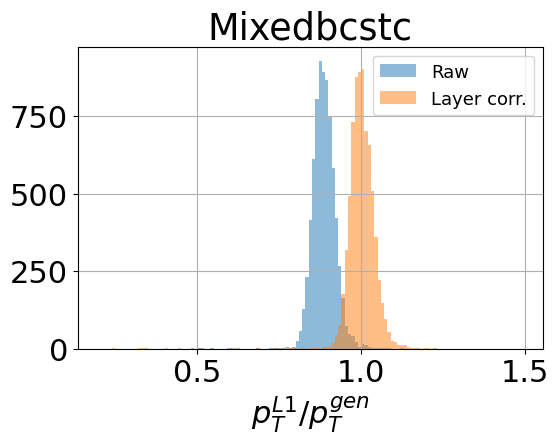

Raw mean=0.8660090565681458, rms=0.041489165276288986, rms/mean=0.047908466309309006
Calib mean=0.9955433501529242, rms=0.052617062790884093, rms/mean=0.05285260835984857


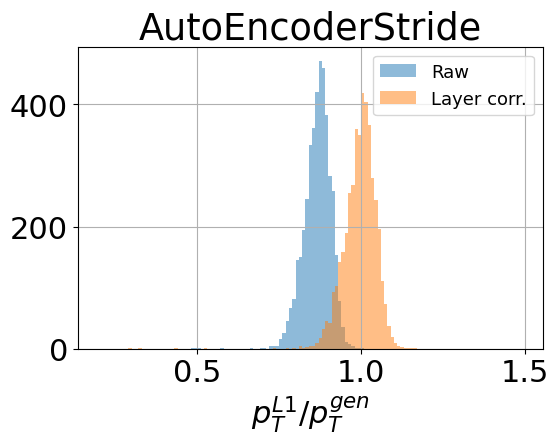

Raw mean=0.9332126379013062, rms=0.03427387773990631, rms/mean=0.03672676160931587
Calib mean=0.9956851290920075, rms=0.04278888488446158, rms/mean=0.042974313499571835


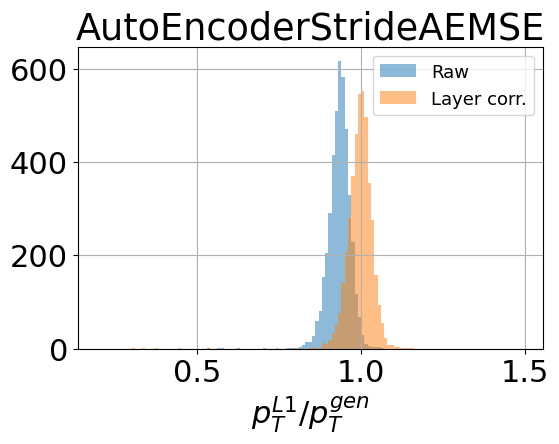

Raw mean=0.9329397678375244, rms=0.038143400102853775, rms/mean=0.04088516905903816
Calib mean=0.9953127326705199, rms=0.04641854359426906, rms/mean=0.04663714435735554


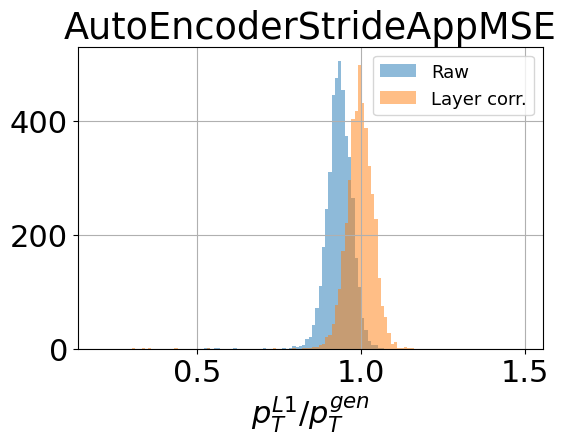

Raw mean=0.9493111371994019, rms=0.034762781113386154, rms/mean=0.03661895543336868
Calib mean=0.9955764850695039, rms=0.042644860434785464, rms/mean=0.04283433877188081


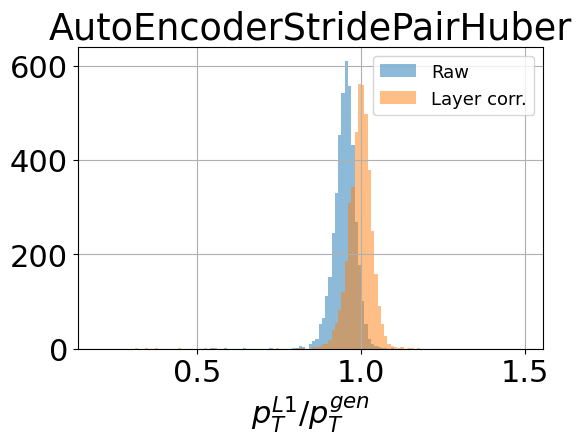

Raw mean=0.8066161870956421, rms=0.06258583068847656, rms/mean=0.07759059965610504
Calib mean=0.9917255208275334, rms=0.08013791212322102, rms/mean=0.08080654419012118


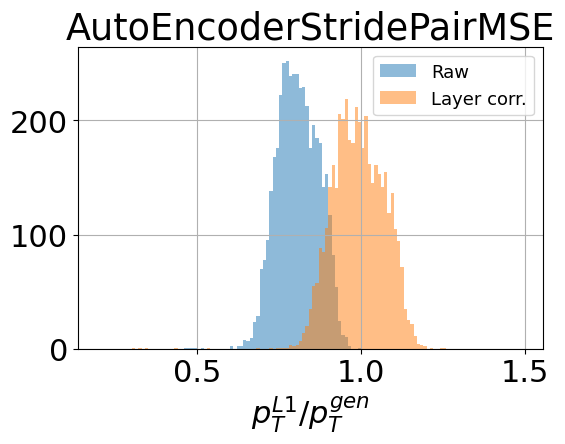

Raw mean=0.9305674433708191, rms=0.03549064323306084, rms/mean=0.03813870996236801
Calib mean=0.9960123535188348, rms=0.04320851896524317, rms/mean=0.04338150908730279


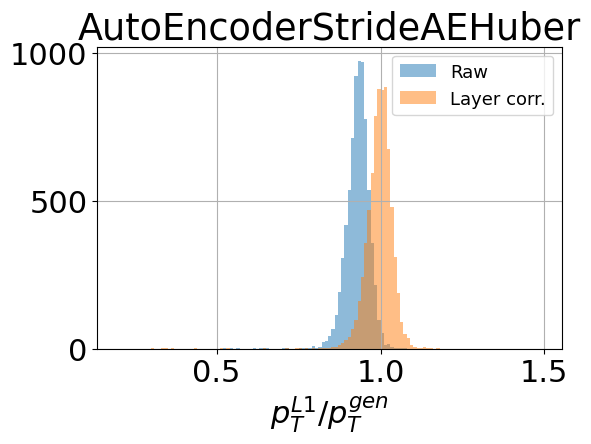

Raw mean=0.9184215068817139, rms=0.036033496260643005, rms/mean=0.039234161376953125
Calib mean=0.9959668187787846, rms=0.04408465586160556, rms/mean=0.044263177276990445


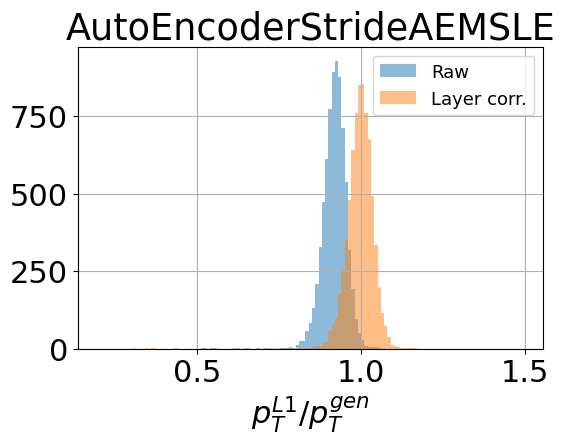

Raw mean=0.9511486887931824, rms=0.03619810938835144, rms/mean=0.03805725648999214
Calib mean=0.9958797804429012, rms=0.04313316302225601, rms/mean=0.043311616391160435


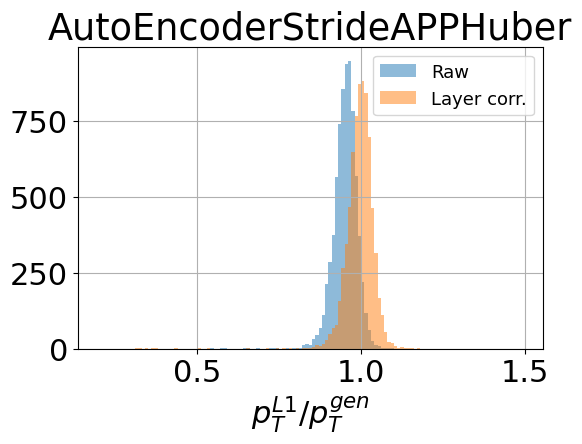

Raw mean=0.9448677897453308, rms=0.036511704325675964, rms/mean=0.03864213079214096
Calib mean=0.9959497620665501, rms=0.04356473327924817, rms/mean=0.04374189837532904


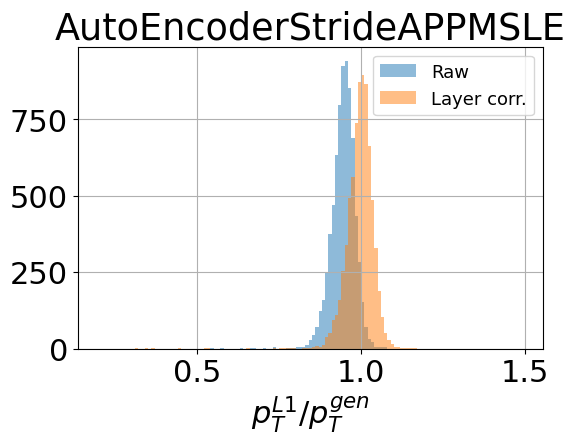

Raw mean=0.9380060434341431, rms=0.035073671489953995, rms/mean=0.03739173337817192
Calib mean=0.9959240391855726, rms=0.04254893479096783, rms/mean=0.04272307235977823


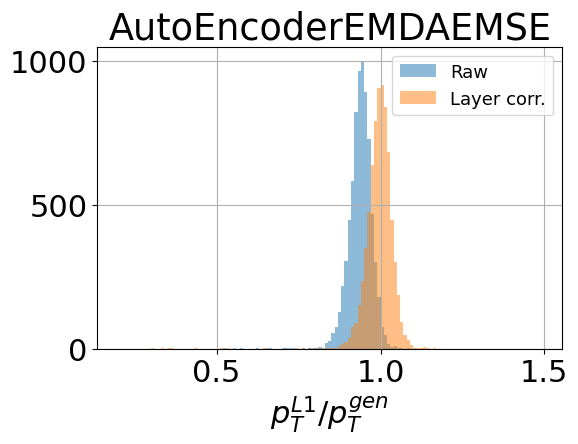

Raw mean=0.9164175391197205, rms=0.04942578822374344, rms/mean=0.05393369868397713
Calib mean=0.9944537744666695, rms=0.05747555310546553, rms/mean=0.057796103329478495


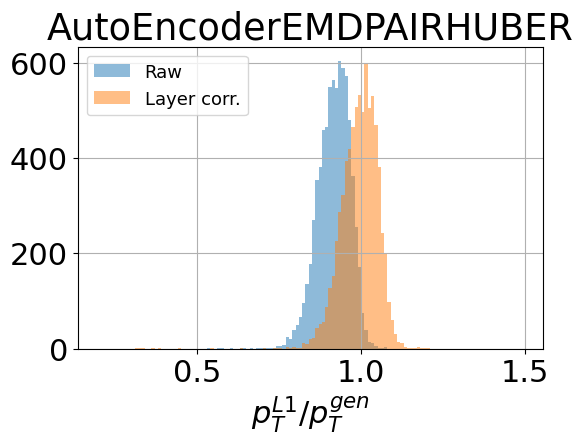

Raw mean=0.8839284181594849, rms=0.03693116828799248, rms/mean=0.04178072139620781
Calib mean=0.9960024281516292, rms=0.04635660657941806, rms/mean=0.04654266422366676


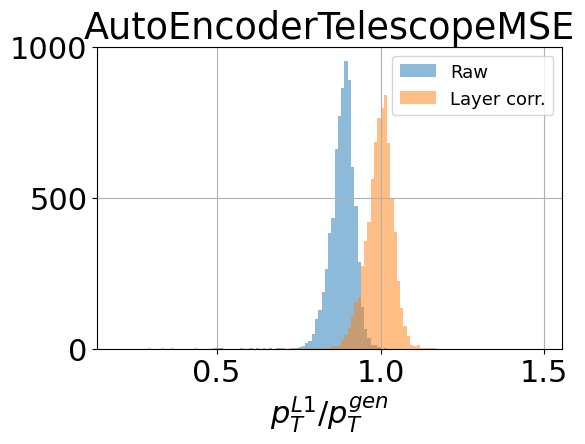

In [16]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==0')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Raw')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0.2, 1.5, 0.01), alpha=0.5, label='Layer corr.')
    plt.title(name)
    plt.legend(fontsize=13)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.grid()
    plt.show()

## eta correction
On 200PU electrons, on top of the layer correction.

Simple linear correction vs eta to correct for PU. This correction is additive, not multiplicative.

In [17]:
corrs = {}
corrs['eta'] = {}
for name,df in algo_cut.items():
    print('  '+name)
    select = df.query('genpart_pid==1')
    X = select[['cl3d_abseta']]
    y = select['genpart_pt']-select['cl3d_pt_calib']
    corrs['eta'][name] = LinearRegression().fit(X, y)

  Threshold0
  Threshold
  Mixedbcstc
  AutoEncoderStride
  AutoEncoderStrideAEMSE
  AutoEncoderStrideAppMSE
  AutoEncoderStridePairHuber
  AutoEncoderStridePairMSE
  AutoEncoderStrideAEHuber
  AutoEncoderStrideAEMSLE
  AutoEncoderStrideAPPHuber
  AutoEncoderStrideAPPMSLE
  AutoEncoderEMDAEMSE
  AutoEncoderEMDPAIRHUBER
  AutoEncoderTelescopeMSE


Print correction value at eta=1.5 and eta=3

In [18]:
for name,df in algo_cut.items():
    corr = corrs['eta'][name]
    print(name)
    print('  eta=1.5:', corr.intercept_+corr.coef_*1.5)
    print('  eta=3:', corr.intercept_+corr.coef_*3)

Threshold0
  eta=1.5: [3.781334]
  eta=3: [-9.665714]
Threshold
  eta=1.5: [3.5408878]
  eta=3: [-9.252296]
Mixedbcstc
  eta=1.5: [4.5651217]
  eta=3: [-3.5633402]
AutoEncoderStride
  eta=1.5: [4.004879]
  eta=3: [-16.116589]
AutoEncoderStrideAEMSE
  eta=1.5: [3.962057]
  eta=3: [-17.291111]
AutoEncoderStrideAppMSE
  eta=1.5: [3.6254425]
  eta=3: [-16.669647]
AutoEncoderStridePairHuber
  eta=1.5: [4.1074543]
  eta=3: [-19.172197]
AutoEncoderStridePairMSE
  eta=1.5: [3.196392]
  eta=3: [-16.716925]
AutoEncoderStrideAEHuber
  eta=1.5: [3.8257694]
  eta=3: [-18.152014]
AutoEncoderStrideAEMSLE
  eta=1.5: [4.21616]
  eta=3: [-18.89088]
AutoEncoderStrideAPPHuber
  eta=1.5: [4.0049133]
  eta=3: [-19.240353]
AutoEncoderStrideAPPMSLE
  eta=1.5: [3.8961487]
  eta=3: [-18.647652]
AutoEncoderEMDAEMSE
  eta=1.5: [3.809761]
  eta=3: [-16.952309]
AutoEncoderEMDPAIRHUBER
  eta=1.5: [3.4198399]
  eta=3: [-18.202484]
AutoEncoderTelescopeMSE
  eta=1.5: [4.255575]
  eta=3: [-16.126545]


In [19]:
for name,df in algo_cut.items():
    df['cl3d_corr_eta'] = corrs['eta'][name].predict(df[['cl3d_abseta']])
    df['cl3d_pt_corr_eta'] =  df['cl3d_corr_eta']+df.cl3d_pt_calib
    df['corr_eta_over_gen_pt'] = df['cl3d_pt_corr_eta']/df['genpart_pt']    

Raw mean=0.9978185296058655, rms=0.12156394869089127, rms/mean=0.12182971835136414
Calib mean=1.0411569026632639, rms=0.10909975775476, rms/mean=0.10478704744278643
Corr eta mean=0.9961625385387638, rms=0.06761294238438842, rms/mean=0.0678734039563137


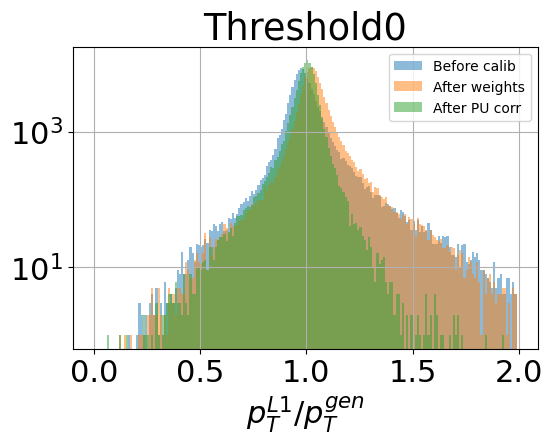

Raw mean=0.9693586826324463, rms=0.09918143600225449, rms/mean=0.10231655091047287
Calib mean=1.032216697262397, rms=0.09967619245577447, rms/mean=0.09656518124549972
Corr eta mean=0.9885203032793932, rms=0.07376606417741868, rms/mean=0.0746227102596694


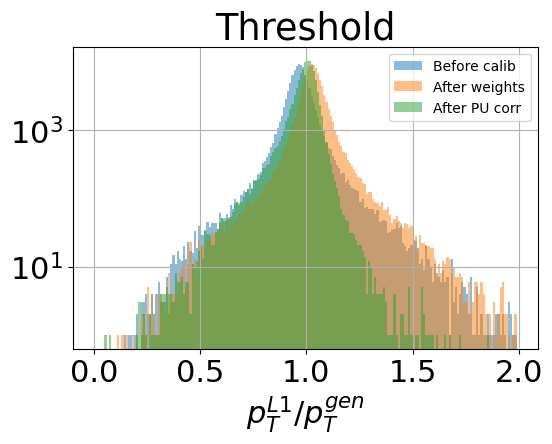

Raw mean=0.8991144299507141, rms=0.08659444004297256, rms/mean=0.0963108092546463
Calib mean=0.9927662986725665, rms=0.07933854336033554, rms/mean=0.07991663643943148
Corr eta mean=1.0016087044605992, rms=0.06774347215643646, rms/mean=0.067634667964391


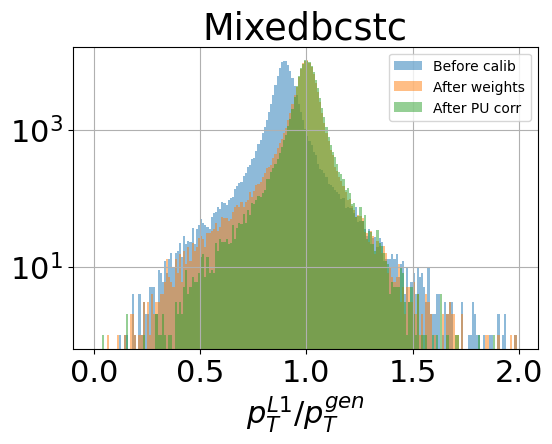

Raw mean=0.9296995997428894, rms=0.13108868896961212, rms/mean=0.1410011202096939
Calib mean=1.0788166835600435, rms=0.13668326834349256, rms/mean=0.1266973994992776
Corr eta mean=0.9853557005430438, rms=0.08953464588711034, rms/mean=0.09086530461818661


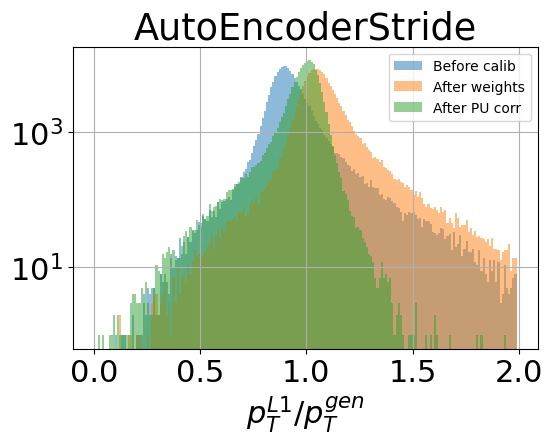

Raw mean=1.0107169151306152, rms=0.14125953614711761, rms/mean=0.13976171612739563
Calib mean=1.085816616779512, rms=0.1373170528004784, rms/mean=0.12646431329053998
Corr eta mean=0.9827703216970635, rms=0.09026223760512468, rms/mean=0.09184469210390726


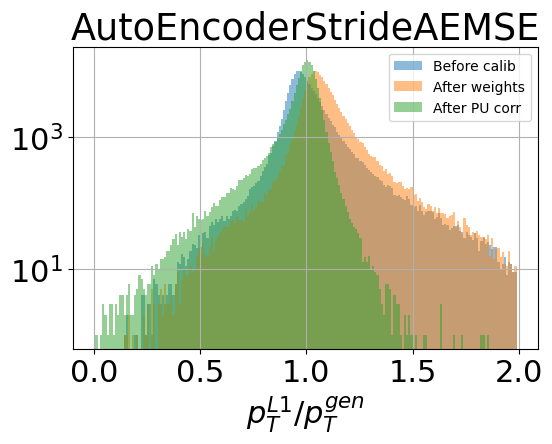

Raw mean=1.007049560546875, rms=0.13826753199100494, rms/mean=0.13729962706565857
Calib mean=1.0835529366536856, rms=0.1345387308764357, rms/mean=0.12416442826681723
Corr eta mean=0.9826450581845331, rms=0.09144146864744684, rms/mean=0.09305645806267807


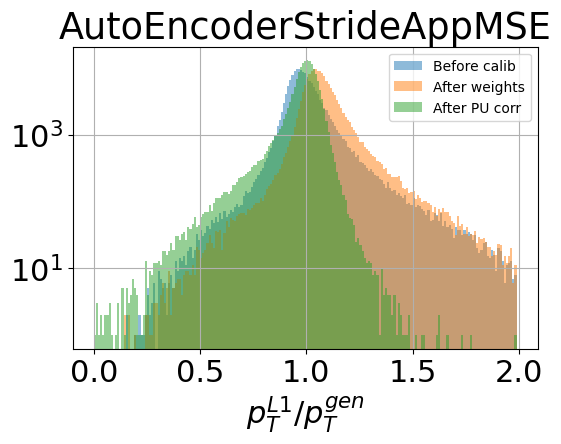

Raw mean=1.0387487411499023, rms=0.15337920188903809, rms/mean=0.14765764772891998
Calib mean=1.0973166041068725, rms=0.14818665823264168, rms/mean=0.135044578454414
Corr eta mean=0.9807321166993932, rms=0.09752565500925069, rms/mean=0.09944168580658762


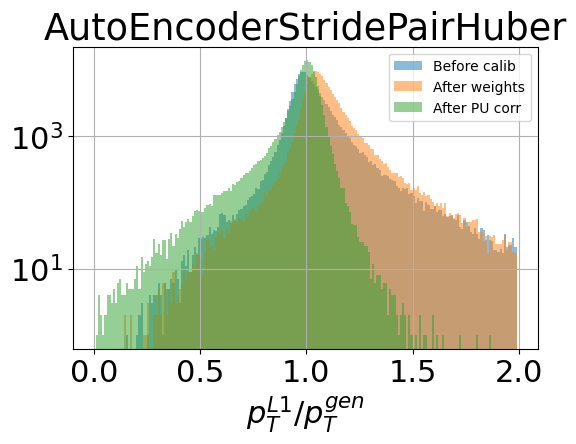

Raw mean=0.873805582523346, rms=0.13863186538219452, rms/mean=0.15865299105644226
Calib mean=1.0906348585564745, rms=0.1583661651599771, rms/mean=0.14520548643529047
Corr eta mean=0.9858958200966936, rms=0.10634244021800844, rms/mean=0.10786377023850116


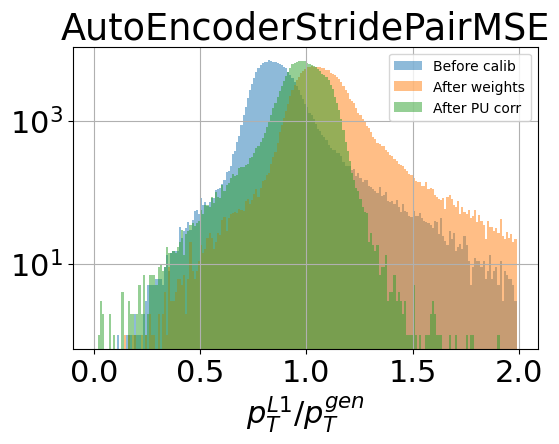

Raw mean=1.0122066736221313, rms=0.14485757052898407, rms/mean=0.14311066269874573
Calib mean=1.0921984341284148, rms=0.14183304608415076, rms/mean=0.12986014413885782
Corr eta mean=0.9814814955476813, rms=0.0939982883068471, rms/mean=0.09577183954384658


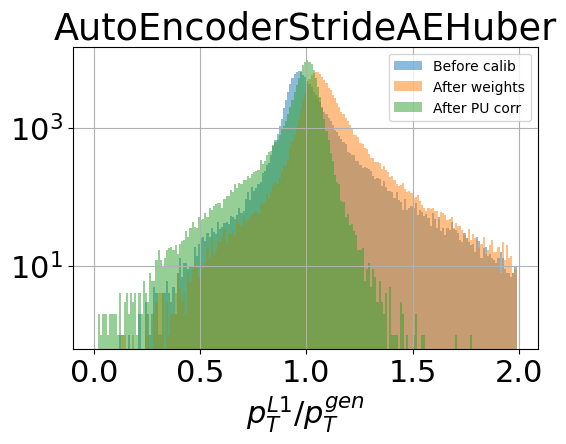

Raw mean=1.003857135772705, rms=0.14954760670661926, rms/mean=0.1489730030298233
Calib mean=1.0956484031205191, rms=0.14857028171543177, rms/mean=0.1356003269774212
Corr eta mean=0.9823257851088356, rms=0.09305426892927036, rms/mean=0.0947285211687287


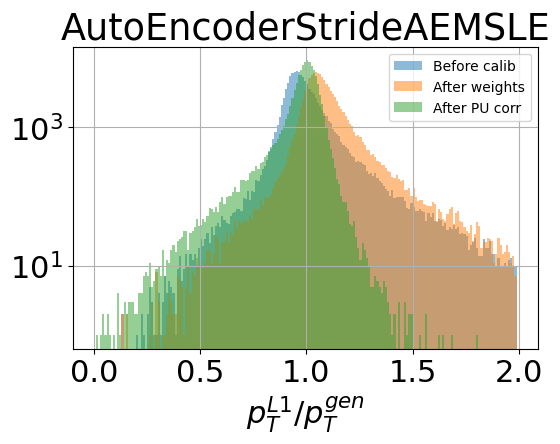

Raw mean=1.0418840646743774, rms=0.1545272320508957, rms/mean=0.1483151912689209
Calib mean=1.098673254763361, rms=0.14822576225391074, rms/mean=0.13491341635128498
Corr eta mean=0.9808580734923648, rms=0.09700946564649388, rms/mean=0.09890265296088122


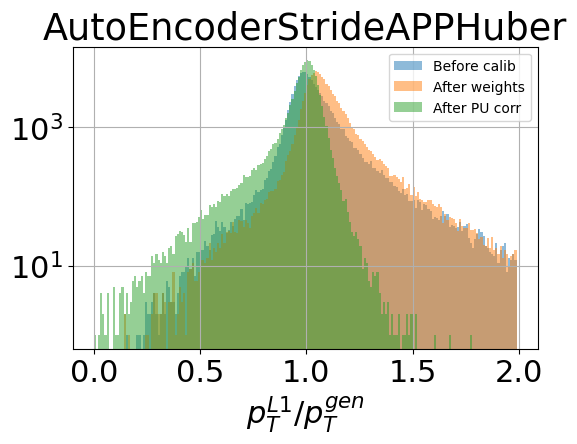

Raw mean=1.0315029621124268, rms=0.14951254427433014, rms/mean=0.14494630694389343
Calib mean=1.0951061390838646, rms=0.1443063822732682, rms/mean=0.1317738775476055
Corr eta mean=0.9810586483925916, rms=0.09567856541876298, rms/mean=0.09752583658023588


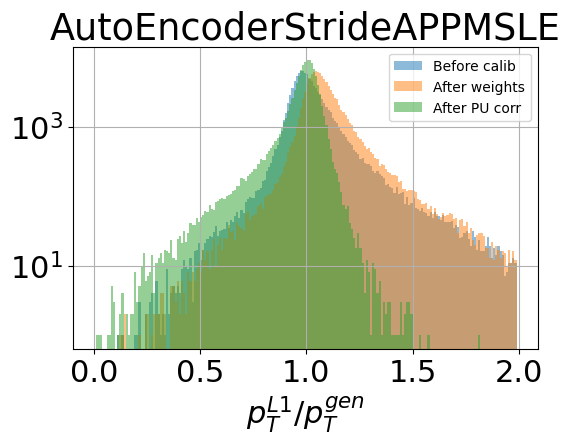

Raw mean=1.0139884948730469, rms=0.13961268961429596, rms/mean=0.13768665492534637
Calib mean=1.0844531012653997, rms=0.13435349253704976, rms/mean=0.12389055126522179
Corr eta mean=0.9826001713372663, rms=0.08953445290933608, rms/mean=0.09111992397424934


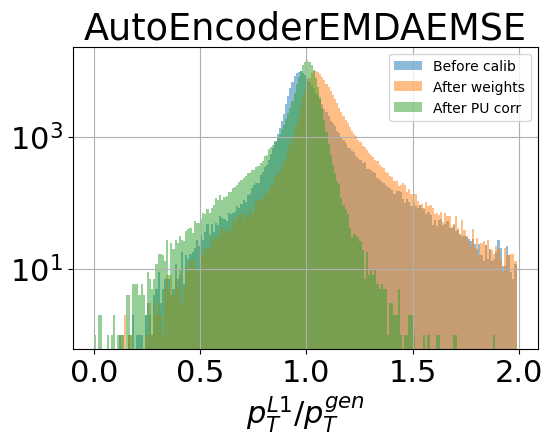

Raw mean=0.9983553290367126, rms=0.14835037291049957, rms/mean=0.14859476685523987
Calib mean=1.0963366270632673, rms=0.14931460472029653, rms/mean=0.13619412234749675
Corr eta mean=0.98165727533098, rms=0.10053172018341687, rms/mean=0.10241020232801834


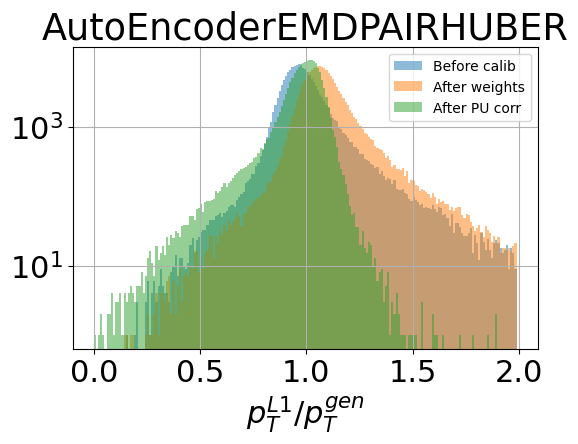

Raw mean=0.950526773929596, rms=0.13254746794700623, rms/mean=0.13944633305072784
Calib mean=1.0775101424582882, rms=0.13417913168507337, rms/mean=0.1245270242922726
Corr eta mean=0.9856785719593002, rms=0.08483302845220947, rms/mean=0.08606561090557249


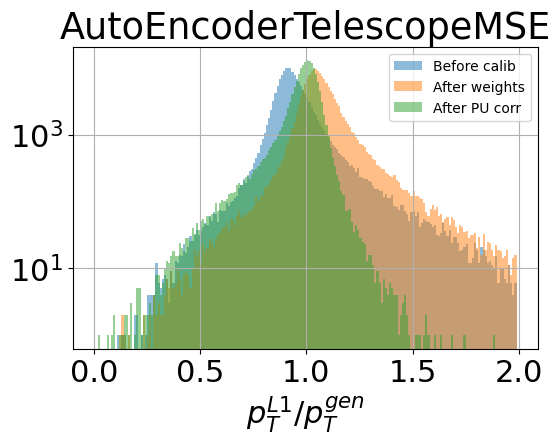

In [20]:
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    print('Raw mean={0}, rms={1}, rms/mean={2}'.format(
        select['cl3d_over_gen_pt'].mean(),
        select['cl3d_over_gen_pt'].std(),
        select['cl3d_over_gen_pt'].std()/select['cl3d_over_gen_pt'].mean()
    ))
    print('Calib mean={0}, rms={1}, rms/mean={2}'.format(
        select['calib_over_gen_pt'].mean(),
        select['calib_over_gen_pt'].std(),
        select['calib_over_gen_pt'].std()/select['calib_over_gen_pt'].mean()
    ))
    print('Corr eta mean={0}, rms={1}, rms/mean={2}'.format(
        select['corr_eta_over_gen_pt'].mean(),
        select['corr_eta_over_gen_pt'].std(),
        select['corr_eta_over_gen_pt'].std()/select['corr_eta_over_gen_pt'].mean()
    ))
    #plt.figure(figsize=(15,10))
    plt.figure(dpi=100)
    plt.hist(select['cl3d_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='Before calib')
    plt.hist(select['calib_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After weights')
    plt.hist(select['corr_eta_over_gen_pt'], bins=np.arange(0., 2., 0.01), alpha=0.5, label='After PU corr')
    plt.grid()
    plt.legend(loc = 'upper right', fontsize=10)
    plt.yscale('log')
    plt.title(name)
    plt.xlabel(r'$p_{T}^{L1}/p_{T}^{gen}$')
    plt.show()

## Final plots
For electrons with 200PU, looking at $p_T > 10\,GeV$
First bin in eta and pT

In [21]:
binetasize = 0.1
binptsize = 5
for name,df in algo_cut.items():
    df['genpart_abseta'] = np.abs(df.genpart_exeta)
    df['genpart_bineta'] = ((df.genpart_abseta - etamin)/binetasize).astype('int32')
    df['genpart_binpt'] = (df.genpart_pt/binptsize).astype('int32')

Compute the mean, RMS, and effective RMS of the pT ratios in each eta and pT bin

In [22]:
def effrms(df, c=0.68):
    """Compute half-width of the shortest interval
    containing a fraction 'c' of items in a 1D array.
    """
    out = {}
    for col in df:
        x = df[col]
        x = np.sort(x, kind="mergesort")
        m = int(c * len(x)) + 1
        out[col] = [np.min(x[m:] - x[:-m]) / 2.0]
    return pd.DataFrame(out).iloc[0]

In [23]:
etameans = {} 
etarmss = {} 
etaeffrmss = {} 
ptmeans = {} 
ptrmss = {} 
pteffrmss = {} 
plot_var = ['genpart_pt', 'genpart_abseta',
            'genpart_bineta', 'genpart_binpt',
           'cl3d_pt', 'cl3d_abseta', 'cl3d_pt_calib',
           'cl3d_pt_corr_eta', 'cl3d_over_gen_pt',
           'calib_over_gen_pt', 'corr_eta_over_gen_pt']
for name,df in algo_cut.items():
    select = df.query('genpart_pid==1 and genpart_pt>10')
    etameans[name] = select[plot_var].groupby('genpart_bineta').mean()
    etarmss[name] = select[plot_var].groupby('genpart_bineta').std()
    etaeffrmss[name] = select[plot_var].groupby('genpart_bineta').apply(effrms)
    ptmeans[name] = select[plot_var].groupby('genpart_binpt').mean()
    ptrmss[name] = select[plot_var].groupby('genpart_binpt').std()
    pteffrmss[name] = select[plot_var].groupby('genpart_binpt').apply(effrms)
    #print(etarmss[name])

Mean vs eta


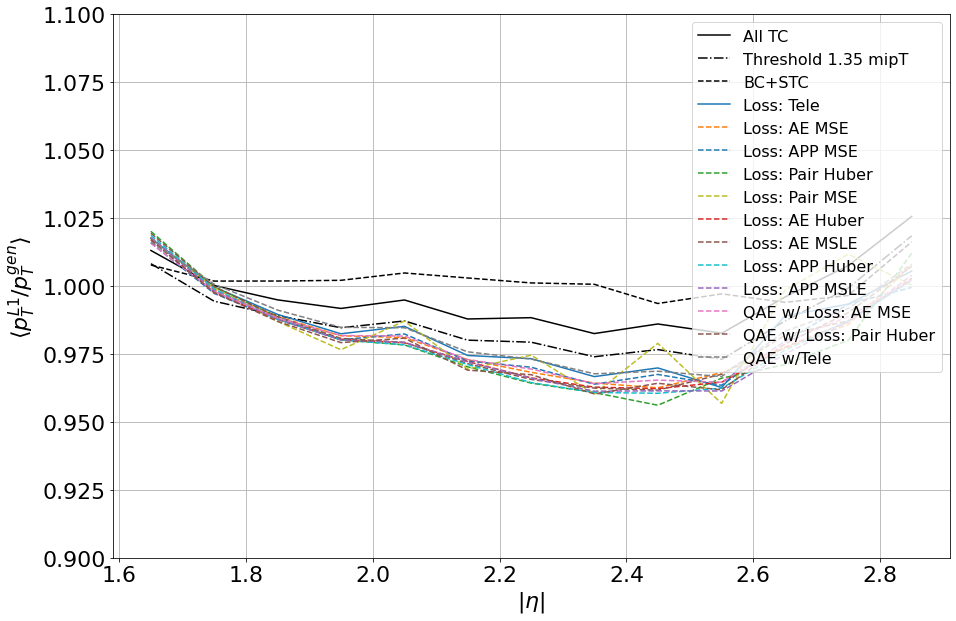

RMS vs eta


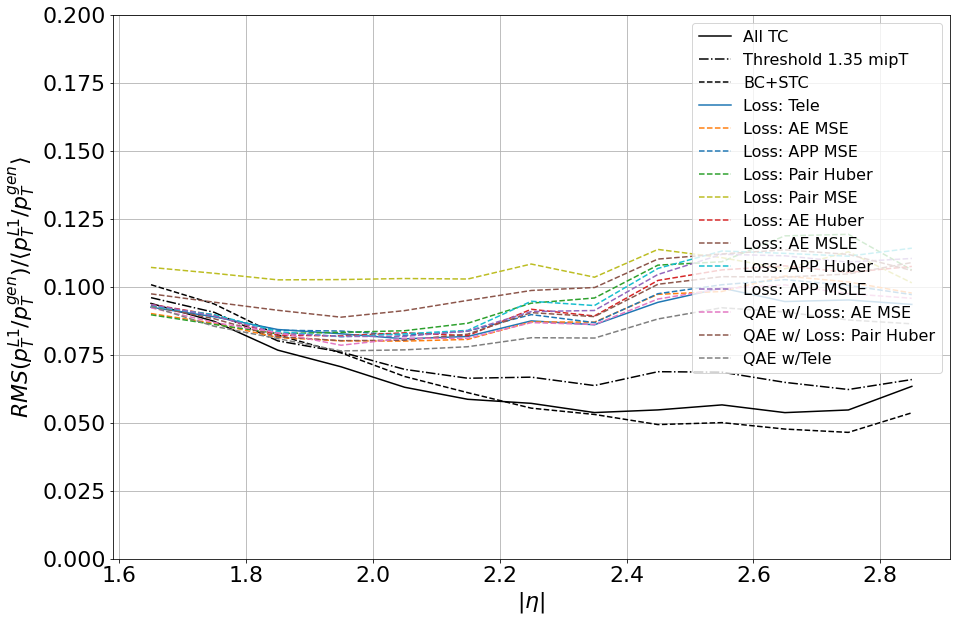

Eff RMS vs eta


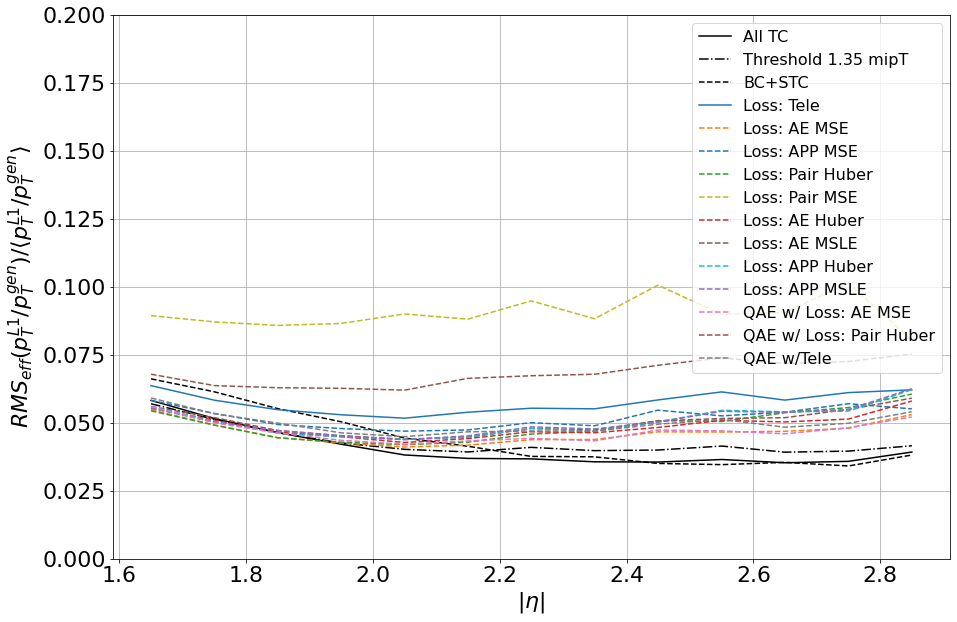

Mean vs pt


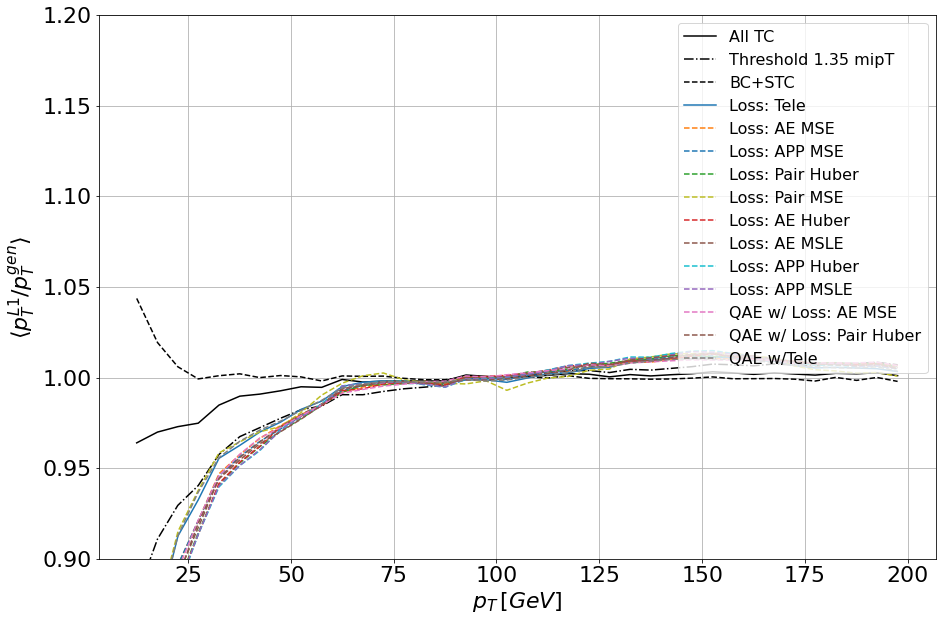

RMS vs pt


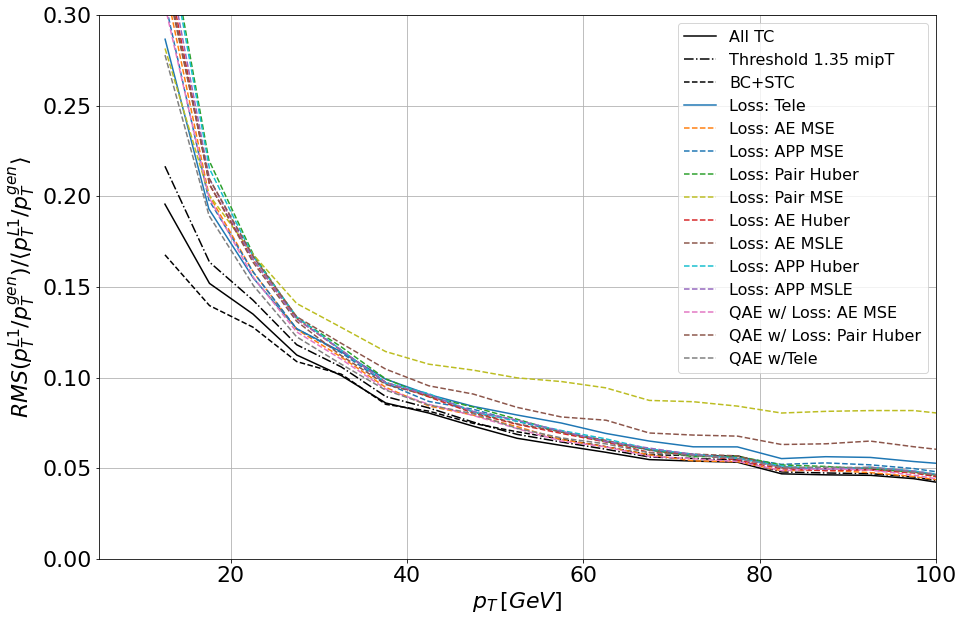

Eff RMS vs pt


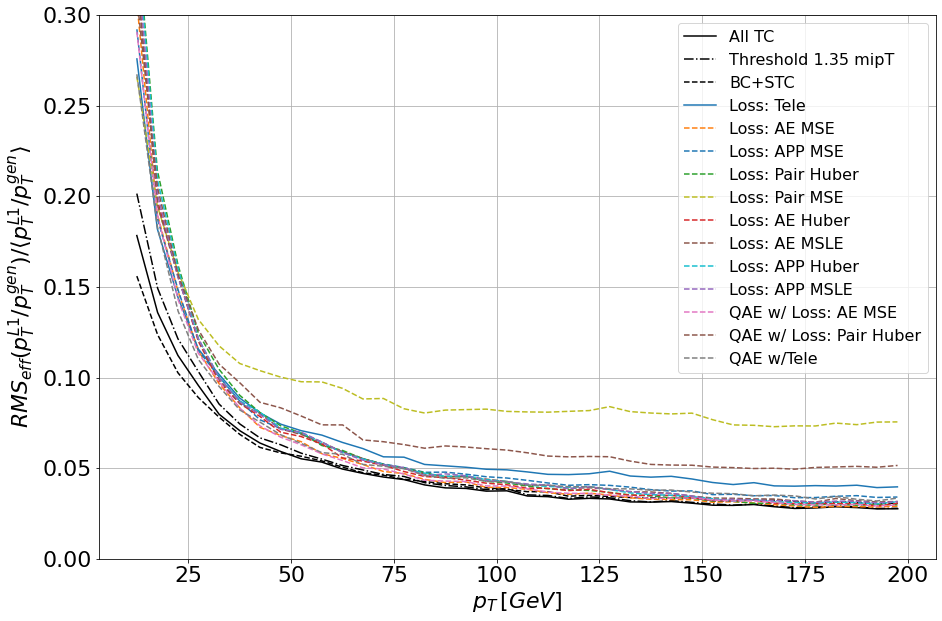

In [24]:
print('Mean vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.1)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etarmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Eff RMS vs eta')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = etameans[name]
    plt.plot(df['genpart_abseta'], etaeffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$|\eta|$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Mean vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0.9, 1.2)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$\langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], ptrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.3)
plt.xlim(5., 100)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()
print('Eff RMS vs pt')
plt.figure(figsize=(15,10))
for name in plotted_algo:
    df = ptmeans[name]
    plt.plot(df['genpart_pt'], pteffrmss[name]['corr_eta_over_gen_pt']/df['corr_eta_over_gen_pt'], color=colors[name], ls=styles[name], label=legends[name])
plt.ylim(0., 0.3)
plt.legend(loc = 'upper right', fontsize=16)
plt.xlabel(r'$p_{T}\, [GeV]$')
plt.ylabel(r'$RMS_{eff}(p_{T}^{L1}/p_{T}^{gen}) / \langle p_{T}^{L1}/p_{T}^{gen}\rangle$')
plt.grid()
plt.show()

## Storing layer weights and eta corrections for external use

In [25]:
with open('/home/cms.rshenoy/data/layer_weights_photons_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(layer_coeffs, f)
    # add  protocol=2 if needed later for python2 in cmssw
with open('/home/cms.rshenoy/data/lineareta_electrons_autoencoder_{}.pkl'.format(version), 'wb') as f:
    pickle.dump(corrs['eta'], f)